In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
from torchsummary import summary

import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline
torch.manual_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Torch version: {torch.__version__}, Device: {device.type}')

Torch version: 2.6.0, Device: mps


In [ ]:
train_data = datasets.CIFAR10(
    root = '../data/',
    train = True,                    
    transform = ToTensor(), 
    download = True,            
)

In [5]:
dataloader = DataLoader(train_data, 50000, shuffle=False, num_workers=2)
X, _ = next(iter(dataloader))
mean, std = torch.mean(X).item(), torch.std(X).item()

In [ ]:
train_data = datasets.CIFAR10(
    root = '../data/',
    train = True,                    
    transform = Compose([ToTensor(), Normalize(mean, std)]),
    download = True,
)

test_data = datasets.CIFAR10(
    root = '../data/', 
    train = False, 
    transform = Compose([ToTensor(), Normalize(mean, std)]),
    download = True
)

In [7]:
train_data, val_data = torch.utils.data.random_split(train_data, [40000, 10000])

## Architecture

In [8]:
class Baseline(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.activation = activation

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

In [9]:
def run_epoch(model, dataloader, optimizer, criterion, train=True):
    """
    Runs one epoch for training or validation.
    """
    epoch_loss = 0
    correct = 0
    total_samples = len(dataloader.dataset)

    if train:
        model.train()
    else:
        model.eval()

    for X, y in tqdm(dataloader, desc=f'{"Train" if train else "Val"} Epoch'):
        X, y = X.to(device), y.to(device)

        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            output = model(X)
            loss = criterion(output, y)

        epoch_loss += loss.item()
        _, y_pred = torch.max(output, dim=1)
        correct += torch.sum(y_pred == y).item()

        if train:
            loss.backward()
            optimizer.step()

    avg_loss = epoch_loss / len(dataloader)
    accuracy = correct / total_samples

    return avg_loss, accuracy

def trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs, patience=None, delta=None):
    """
    Trains and evaluates the model for n_epochs.
    """
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accs = []
    epoch_val_accs = []

    best_val_loss = float('inf')
    counter = 0

    for epoch in range(n_epochs):

        print(f'\nEpoch {epoch+1}/{n_epochs}')
        print('----------')

        train_loss, train_acc = run_epoch(model, train_loader, optimizer, criterion, train=True)
        val_loss, val_acc = run_epoch(model, val_loader, optimizer, criterion, train=False)
            
        epoch_train_losses.append(train_loss)
        epoch_val_losses.append(val_loss)
        epoch_train_accs.append(train_acc)
        epoch_val_accs.append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}\nVal Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        if patience == None and delta == None:
            continue
        else:
            if val_loss < best_val_loss - delta:
                best_val_loss = val_loss
                counter = 0
            else:
                counter += 1
                print(f'Val loss has not increased for {counter}/{patience} epochs')
                if counter >= patience:
                    print(f'Training stopped after {epoch+1} epochs')
                    break
    
    return epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs

## Init

In [10]:
results = {}
n_epochs = 10

train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
val_loader = DataLoader(val_data, batch_size=512, shuffle=False)


## Baseline with ReLU

In [11]:
model = Baseline(activation=nn.ReLU()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
results['baseline_relu'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.01it/s]


Train Loss: 1.8545, Train Accuracy: 0.3134
Val Loss: 1.6456, Val Accuracy: 0.4016

Epoch 2/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.31it/s]


Train Loss: 1.4976, Train Accuracy: 0.4496
Val Loss: 1.4641, Val Accuracy: 0.4761

Epoch 3/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.43it/s]


Train Loss: 1.3656, Train Accuracy: 0.5062
Val Loss: 1.3235, Val Accuracy: 0.5244

Epoch 4/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 23.79it/s]


Train Loss: 1.2548, Train Accuracy: 0.5485
Val Loss: 1.2476, Val Accuracy: 0.5636

Epoch 5/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.86it/s]


Train Loss: 1.1789, Train Accuracy: 0.5795
Val Loss: 1.2730, Val Accuracy: 0.5448

Epoch 6/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 26.10it/s]


Train Loss: 1.1061, Train Accuracy: 0.6075
Val Loss: 1.1463, Val Accuracy: 0.5993

Epoch 7/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.48it/s]


Train Loss: 1.0356, Train Accuracy: 0.6332
Val Loss: 1.1142, Val Accuracy: 0.6025

Epoch 8/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Train Loss: 0.9869, Train Accuracy: 0.6498
Val Loss: 1.0552, Val Accuracy: 0.6334

Epoch 9/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.85it/s]


Train Loss: 0.9288, Train Accuracy: 0.6702
Val Loss: 0.9694, Val Accuracy: 0.6616

Epoch 10/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.55it/s]

Train Loss: 0.8939, Train Accuracy: 0.6844
Val Loss: 1.0198, Val Accuracy: 0.6530


## Baseline with Tanh

In [12]:
model = Baseline(activation=nn.Tanh()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
results['baseline_tanh'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.67it/s]


Train Loss: 1.6990, Train Accuracy: 0.3908
Val Loss: 1.4460, Val Accuracy: 0.4718

Epoch 2/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.09it/s]


Train Loss: 1.2823, Train Accuracy: 0.5382
Val Loss: 1.1946, Val Accuracy: 0.5785

Epoch 3/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.38it/s]


Train Loss: 1.0926, Train Accuracy: 0.6121
Val Loss: 1.0882, Val Accuracy: 0.6137

Epoch 4/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.86it/s]


Train Loss: 0.9724, Train Accuracy: 0.6550
Val Loss: 0.9820, Val Accuracy: 0.6582

Epoch 5/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.98it/s]


Train Loss: 0.8804, Train Accuracy: 0.6908
Val Loss: 0.9202, Val Accuracy: 0.6796

Epoch 6/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 23.06it/s]


Train Loss: 0.7938, Train Accuracy: 0.7213
Val Loss: 0.8553, Val Accuracy: 0.7028

Epoch 7/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 22.90it/s]


Train Loss: 0.7191, Train Accuracy: 0.7533
Val Loss: 0.8515, Val Accuracy: 0.7028

Epoch 8/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Train Loss: 0.6566, Train Accuracy: 0.7739
Val Loss: 0.8315, Val Accuracy: 0.7113

Epoch 9/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 26.02it/s]


Train Loss: 0.6133, Train Accuracy: 0.7883
Val Loss: 0.8181, Val Accuracy: 0.7176

Epoch 10/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.14it/s]

Train Loss: 0.5583, Train Accuracy: 0.8055
Val Loss: 0.8310, Val Accuracy: 0.7173


## BatchNorm

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(8*8*32, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.activation = activation
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm1d(512)
        self.bn4 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = self.flatten(x)
        x = self.activation(self.bn3(self.fc1(x)))
        x = self.activation(self.bn4(self.fc2(x)))
        return self.fc3(x)

In [14]:
activations = {'relu': nn.ReLU(), 'tanh': nn.Tanh()}

for name, function in activations.items():
    model = BatchNorm(activation=function).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
    results[f'batchnorm_{name}'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 82.88it/s]


Train Loss: 1.1776, Train Accuracy: 0.5815
Val Loss: 0.9865, Val Accuracy: 0.6482

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 85.26it/s]


Train Loss: 0.8089, Train Accuracy: 0.7147
Val Loss: 0.8482, Val Accuracy: 0.7016

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 72.34it/s]


Train Loss: 0.6226, Train Accuracy: 0.7815
Val Loss: 0.8838, Val Accuracy: 0.6909

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 77.48it/s]


Train Loss: 0.4646, Train Accuracy: 0.8387
Val Loss: 0.9465, Val Accuracy: 0.6905

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 80.77it/s]


Train Loss: 0.3191, Train Accuracy: 0.8904
Val Loss: 0.9285, Val Accuracy: 0.7134

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 79.77it/s]


Train Loss: 0.2218, Train Accuracy: 0.9258
Val Loss: 1.0063, Val Accuracy: 0.7100

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 87.37it/s]


Train Loss: 0.1498, Train Accuracy: 0.9505
Val Loss: 1.1199, Val Accuracy: 0.7109

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 84.44it/s]


Train Loss: 0.1073, Train Accuracy: 0.9651
Val Loss: 1.1996, Val Accuracy: 0.7036

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 82.20it/s]


Train Loss: 0.0873, Train Accuracy: 0.9714
Val Loss: 1.2026, Val Accuracy: 0.7138

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 69.25it/s]


Train Loss: 0.0806, Train Accuracy: 0.9727
Val Loss: 1.2784, Val Accuracy: 0.7115

Epoch 1/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 85.67it/s]


Train Loss: 1.3577, Train Accuracy: 0.5188
Val Loss: 1.1773, Val Accuracy: 0.5867

Epoch 2/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 79.43it/s]


Train Loss: 1.0317, Train Accuracy: 0.6388
Val Loss: 1.0299, Val Accuracy: 0.6425

Epoch 3/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 69.84it/s]


Train Loss: 0.8816, Train Accuracy: 0.6928
Val Loss: 0.9918, Val Accuracy: 0.6548

Epoch 4/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 78.93it/s]


Train Loss: 0.7747, Train Accuracy: 0.7287
Val Loss: 0.9195, Val Accuracy: 0.6857

Epoch 5/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 79.97it/s]


Train Loss: 0.6839, Train Accuracy: 0.7607
Val Loss: 0.9434, Val Accuracy: 0.6787

Epoch 6/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 71.59it/s]


Train Loss: 0.5810, Train Accuracy: 0.7971
Val Loss: 0.9540, Val Accuracy: 0.6840

Epoch 7/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 80.39it/s]


Train Loss: 0.4882, Train Accuracy: 0.8313
Val Loss: 1.0003, Val Accuracy: 0.6784

Epoch 8/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 76.97it/s]


Train Loss: 0.3923, Train Accuracy: 0.8667
Val Loss: 1.0040, Val Accuracy: 0.6942

Epoch 9/10
----------


Val Epoch: 100%|██████████| 79/79 [00:01<00:00, 77.42it/s]


Train Loss: 0.3055, Train Accuracy: 0.8961
Val Loss: 1.1308, Val Accuracy: 0.6818

Epoch 10/10
----------


Val Epoch: 100%|██████████| 79/79 [00:00<00:00, 82.08it/s]

Train Loss: 0.2197, Train Accuracy: 0.9263
Val Loss: 1.3104, Val Accuracy: 0.6685


## Dropout without BatchNorm

In [18]:
class Dropout(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.activation = activation
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = self.pool(self.activation(self.conv3(x)))
        x = self.flatten(x)
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.dropout(self.activation(self.fc2(x)))
        return self.fc3(x)

In [19]:
activations = {'relu': nn.ReLU(), 'tanh': nn.Tanh()}

for name, function in activations.items():
    model = Dropout(activation=function).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
    results[f'dropout_{name}'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Train Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.25it/s]


Train Loss: 2.0427, Train Accuracy: 0.2394
Val Loss: 1.7120, Val Accuracy: 0.3955

Epoch 2/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.38it/s]


Train Loss: 1.6813, Train Accuracy: 0.3725
Val Loss: 1.5162, Val Accuracy: 0.4614

Epoch 3/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 26.38it/s]


Train Loss: 1.5209, Train Accuracy: 0.4404
Val Loss: 1.3415, Val Accuracy: 0.5160

Epoch 4/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.41it/s]


Train Loss: 1.4170, Train Accuracy: 0.4872
Val Loss: 1.2411, Val Accuracy: 0.5573

Epoch 5/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.43it/s]


Train Loss: 1.3327, Train Accuracy: 0.5202
Val Loss: 1.1773, Val Accuracy: 0.5815

Epoch 6/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.22it/s]


Train Loss: 1.2488, Train Accuracy: 0.5550
Val Loss: 1.1236, Val Accuracy: 0.5990

Epoch 7/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.26it/s]


Train Loss: 1.2016, Train Accuracy: 0.5744
Val Loss: 1.0813, Val Accuracy: 0.6120

Epoch 8/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 23.49it/s]


Train Loss: 1.1362, Train Accuracy: 0.5990
Val Loss: 1.0442, Val Accuracy: 0.6271

Epoch 9/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 23.37it/s]


Train Loss: 1.0872, Train Accuracy: 0.6203
Val Loss: 0.9674, Val Accuracy: 0.6578

Epoch 10/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Train Loss: 1.0396, Train Accuracy: 0.6354
Val Loss: 0.9586, Val Accuracy: 0.6627

Epoch 1/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.27it/s]


Train Loss: 1.8243, Train Accuracy: 0.3312
Val Loss: 1.4533, Val Accuracy: 0.4822

Epoch 2/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.69it/s]


Train Loss: 1.4328, Train Accuracy: 0.4831
Val Loss: 1.2729, Val Accuracy: 0.5426

Epoch 3/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.89it/s]


Train Loss: 1.2814, Train Accuracy: 0.5445
Val Loss: 1.1362, Val Accuracy: 0.5936

Epoch 4/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.68it/s]


Train Loss: 1.1739, Train Accuracy: 0.5861
Val Loss: 1.0622, Val Accuracy: 0.6280

Epoch 5/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.03it/s]


Train Loss: 1.0924, Train Accuracy: 0.6149
Val Loss: 1.0111, Val Accuracy: 0.6449

Epoch 6/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.35it/s]


Train Loss: 1.0272, Train Accuracy: 0.6446
Val Loss: 0.9263, Val Accuracy: 0.6786

Epoch 7/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 23.70it/s]


Train Loss: 0.9824, Train Accuracy: 0.6618
Val Loss: 0.9786, Val Accuracy: 0.6620

Epoch 8/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 22.35it/s]


Train Loss: 0.9480, Train Accuracy: 0.6746
Val Loss: 0.8852, Val Accuracy: 0.6928

Epoch 9/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.32it/s]


Train Loss: 0.8979, Train Accuracy: 0.6913
Val Loss: 0.8605, Val Accuracy: 0.7078

Epoch 10/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 22.89it/s]

Train Loss: 0.8617, Train Accuracy: 0.7052
Val Loss: 0.8514, Val Accuracy: 0.7084


## Dropout with BatchNorm

In [20]:
class DropoutBatchNorm(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.activation = activation
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.pool(self.activation(self.bn1(self.conv1(x))))
        x = self.pool(self.activation(self.bn2(self.conv2(x))))
        x = self.pool(self.activation(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = self.dropout(self.activation(self.bn4(self.fc1(x))))
        x = self.dropout(self.activation(self.bn5(self.fc2(x))))
        return self.fc3(x)

In [21]:
model = DropoutBatchNorm(activation=nn.ReLU()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
results[f'dropout_batchnorm_relu'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Train Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 23.84it/s]


Train Loss: 1.7860, Train Accuracy: 0.3654
Val Loss: 1.3521, Val Accuracy: 0.5428

Epoch 2/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.84it/s]


Train Loss: 1.3457, Train Accuracy: 0.5327
Val Loss: 1.2573, Val Accuracy: 0.5495

Epoch 3/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.70it/s]


Train Loss: 1.1439, Train Accuracy: 0.6077
Val Loss: 0.9579, Val Accuracy: 0.6701

Epoch 4/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.01it/s]


Train Loss: 1.0416, Train Accuracy: 0.6474
Val Loss: 0.9001, Val Accuracy: 0.6900

Epoch 5/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.27it/s]


Train Loss: 0.9480, Train Accuracy: 0.6796
Val Loss: 0.8545, Val Accuracy: 0.7050

Epoch 6/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.75it/s]


Train Loss: 0.8829, Train Accuracy: 0.7053
Val Loss: 0.8065, Val Accuracy: 0.7228

Epoch 7/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 22.72it/s]


Train Loss: 0.8172, Train Accuracy: 0.7275
Val Loss: 0.8381, Val Accuracy: 0.7115

Epoch 8/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.77it/s]


Train Loss: 0.7758, Train Accuracy: 0.7406
Val Loss: 0.8113, Val Accuracy: 0.7207

Epoch 9/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 23.27it/s]


Train Loss: 0.7332, Train Accuracy: 0.7583
Val Loss: 0.8083, Val Accuracy: 0.7247

Epoch 10/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 21.18it/s]

Train Loss: 0.6934, Train Accuracy: 0.7672
Val Loss: 0.7698, Val Accuracy: 0.7379


## More Epochs

In [22]:
n_epochs = 20

model = DropoutBatchNorm(activation=nn.ReLU()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)


Epoch 1/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.34it/s]


Train Loss: 1.7737, Train Accuracy: 0.3666
Val Loss: 1.4102, Val Accuracy: 0.5345

Epoch 2/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.97it/s]


Train Loss: 1.3402, Train Accuracy: 0.5323
Val Loss: 1.1279, Val Accuracy: 0.6149

Epoch 3/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.40it/s]


Train Loss: 1.1564, Train Accuracy: 0.6011
Val Loss: 1.0099, Val Accuracy: 0.6531

Epoch 4/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 23.50it/s]


Train Loss: 1.0302, Train Accuracy: 0.6475
Val Loss: 0.9704, Val Accuracy: 0.6643

Epoch 5/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.42it/s]


Train Loss: 0.9403, Train Accuracy: 0.6835
Val Loss: 0.8696, Val Accuracy: 0.7006

Epoch 6/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.96it/s]


Train Loss: 0.8880, Train Accuracy: 0.7013
Val Loss: 0.8455, Val Accuracy: 0.7054

Epoch 7/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.15it/s]


Train Loss: 0.8228, Train Accuracy: 0.7237
Val Loss: 0.8485, Val Accuracy: 0.7065

Epoch 8/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.98it/s]


Train Loss: 0.7788, Train Accuracy: 0.7425
Val Loss: 0.8961, Val Accuracy: 0.7015

Epoch 9/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.80it/s]


Train Loss: 0.7421, Train Accuracy: 0.7519
Val Loss: 0.8190, Val Accuracy: 0.7268

Epoch 10/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.27it/s]


Train Loss: 0.6947, Train Accuracy: 0.7689
Val Loss: 0.7903, Val Accuracy: 0.7296

Epoch 11/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.86it/s]


Train Loss: 0.6602, Train Accuracy: 0.7811
Val Loss: 0.7772, Val Accuracy: 0.7373

Epoch 12/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.71it/s]


Train Loss: 0.6363, Train Accuracy: 0.7890
Val Loss: 0.7621, Val Accuracy: 0.7442

Epoch 13/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 23.76it/s]


Train Loss: 0.5947, Train Accuracy: 0.8044
Val Loss: 0.7801, Val Accuracy: 0.7388

Epoch 14/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 25.02it/s]


Train Loss: 0.5653, Train Accuracy: 0.8139
Val Loss: 0.7496, Val Accuracy: 0.7550

Epoch 15/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.98it/s]


Train Loss: 0.5442, Train Accuracy: 0.8196
Val Loss: 0.8067, Val Accuracy: 0.7414

Epoch 16/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.10it/s]


Train Loss: 0.5140, Train Accuracy: 0.8314
Val Loss: 0.8185, Val Accuracy: 0.7359

Epoch 17/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 23.97it/s]


Train Loss: 0.4925, Train Accuracy: 0.8374
Val Loss: 0.7736, Val Accuracy: 0.7533

Epoch 18/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.69it/s]


Train Loss: 0.4791, Train Accuracy: 0.8425
Val Loss: 0.7924, Val Accuracy: 0.7434

Epoch 19/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.35it/s]


Train Loss: 0.4646, Train Accuracy: 0.8513
Val Loss: 0.8195, Val Accuracy: 0.7469

Epoch 20/20
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.03it/s]

Train Loss: 0.4616, Train Accuracy: 0.8491
Val Loss: 0.7814, Val Accuracy: 0.7562


How far can you bring up the test accuracy by continuing the training
possibly over more epochs?

## figs and nuts version

In [23]:
class FigNuts(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.activation = activation
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout()

    def forward(self, x):
        x = self.pool(self.bn1(self.activation(self.conv1(x))))
        x = self.pool(self.bn2(self.activation(self.conv2(x))))
        x = self.pool(self.bn3(self.activation(self.conv3(x))))
        x = self.flatten(x)
        x = self.bn4(self.dropout(self.activation(self.fc1(x))))
        x = self.bn5(self.dropout(self.activation(self.fc2(x))))
        return self.fc3(x)

In [24]:
n_epochs = 10

model = FigNuts(activation=nn.ReLU()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)
results[f'fig_and_nuts_relu'] = [epoch_train_losses, epoch_val_losses, epoch_train_accs, epoch_val_accs]


Epoch 1/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.82it/s]


Train Loss: 1.8245, Train Accuracy: 0.3481
Val Loss: 1.3933, Val Accuracy: 0.5194

Epoch 2/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.59it/s]


Train Loss: 1.3750, Train Accuracy: 0.5143
Val Loss: 1.1230, Val Accuracy: 0.6154

Epoch 3/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 24.41it/s]


Train Loss: 1.1592, Train Accuracy: 0.6036
Val Loss: 0.9681, Val Accuracy: 0.6684

Epoch 4/10
----------


Val Epoch: 100%|██████████| 20/20 [00:00<00:00, 22.48it/s]


Train Loss: 1.0222, Train Accuracy: 0.6552
Val Loss: 0.8695, Val Accuracy: 0.6999

Epoch 5/10
----------


Val Epoch: 100%|██████████| 20/20 [00:01<00:00, 18.37it/s]


Train Loss: 0.9477, Train Accuracy: 0.6848
Val Loss: 0.8968, Val Accuracy: 0.6913

Epoch 6/10
----------


Val Epoch: 100%|██████████| 20/20 [00:01<00:00, 15.16it/s]


Train Loss: 0.8748, Train Accuracy: 0.7108
Val Loss: 0.8102, Val Accuracy: 0.7261

Epoch 7/10
----------


Val Epoch: 100%|██████████| 20/20 [00:01<00:00, 14.67it/s]


Train Loss: 0.7872, Train Accuracy: 0.7401
Val Loss: 0.7758, Val Accuracy: 0.7327

Epoch 8/10
----------


Val Epoch: 100%|██████████| 20/20 [00:01<00:00, 13.50it/s]


Train Loss: 0.7396, Train Accuracy: 0.7574
Val Loss: 0.7697, Val Accuracy: 0.7380

Epoch 9/10
----------


Val Epoch: 100%|██████████| 20/20 [00:01<00:00, 13.81it/s]


Train Loss: 0.6949, Train Accuracy: 0.7708
Val Loss: 0.7498, Val Accuracy: 0.7470

Epoch 10/10
----------


Val Epoch: 100%|██████████| 20/20 [00:01<00:00, 13.99it/s]

Train Loss: 0.6612, Train Accuracy: 0.7839
Val Loss: 0.7565, Val Accuracy: 0.7525


## Comparison

In [25]:
def plot_loss_curves(n_epochs, results):
    
    fig, ax = plt.subplots(2, 2, figsize=(24,18))
    
    line_styles = ['-', '--', '-.', ':']
    colors = plt.cm.tab10.colors
    
    for i, (name, metric) in enumerate(results.items()):

        style = random.choice(line_styles)
        color = colors[i % len(colors)]

        x = range(1, n_epochs + 1)

        ax[0, 0].plot(x, metric[0], linestyle=style, color=color, label=name)
        ax[0, 0].set_title('Train Loss')
        ax[0, 0].set_ylabel('Loss')
        ax[0, 0].set_ylim(0, 1.7)

        ax[0, 1].plot(x, metric[1], linestyle=style, color=color, label=name)
        ax[0, 1].set_title('Validation Loss')
        ax[0, 1].set_ylabel('Loss')
        ax[0, 1].set_ylim(0, 1.7)
        
        ax[1, 0].plot(x, metric[2], linestyle=style, color=color, label=name)
        ax[1, 0].set_title('Train Accuracy')
        ax[1, 0].set_ylabel('Accuracy')
        ax[1, 0].set_ylim(0.4, 1)

        ax[1, 1].plot(x, metric[3], linestyle=style, color=color, label=name)
        ax[1, 1].set_title('Validation Accuracy')
        ax[1, 1].set_ylabel('Accuracy')
        ax[1, 1].set_ylim(0.4, 1)
        
    for axes in ax.flat:
        axes.set_xlabel('Epochs')
        axes.set_xticks(range(1, n_epochs+1))
        axes.grid()
        axes.legend()

    fig.suptitle('Train/Val Losses and Accuracies', fontsize=18)
    plt.show()

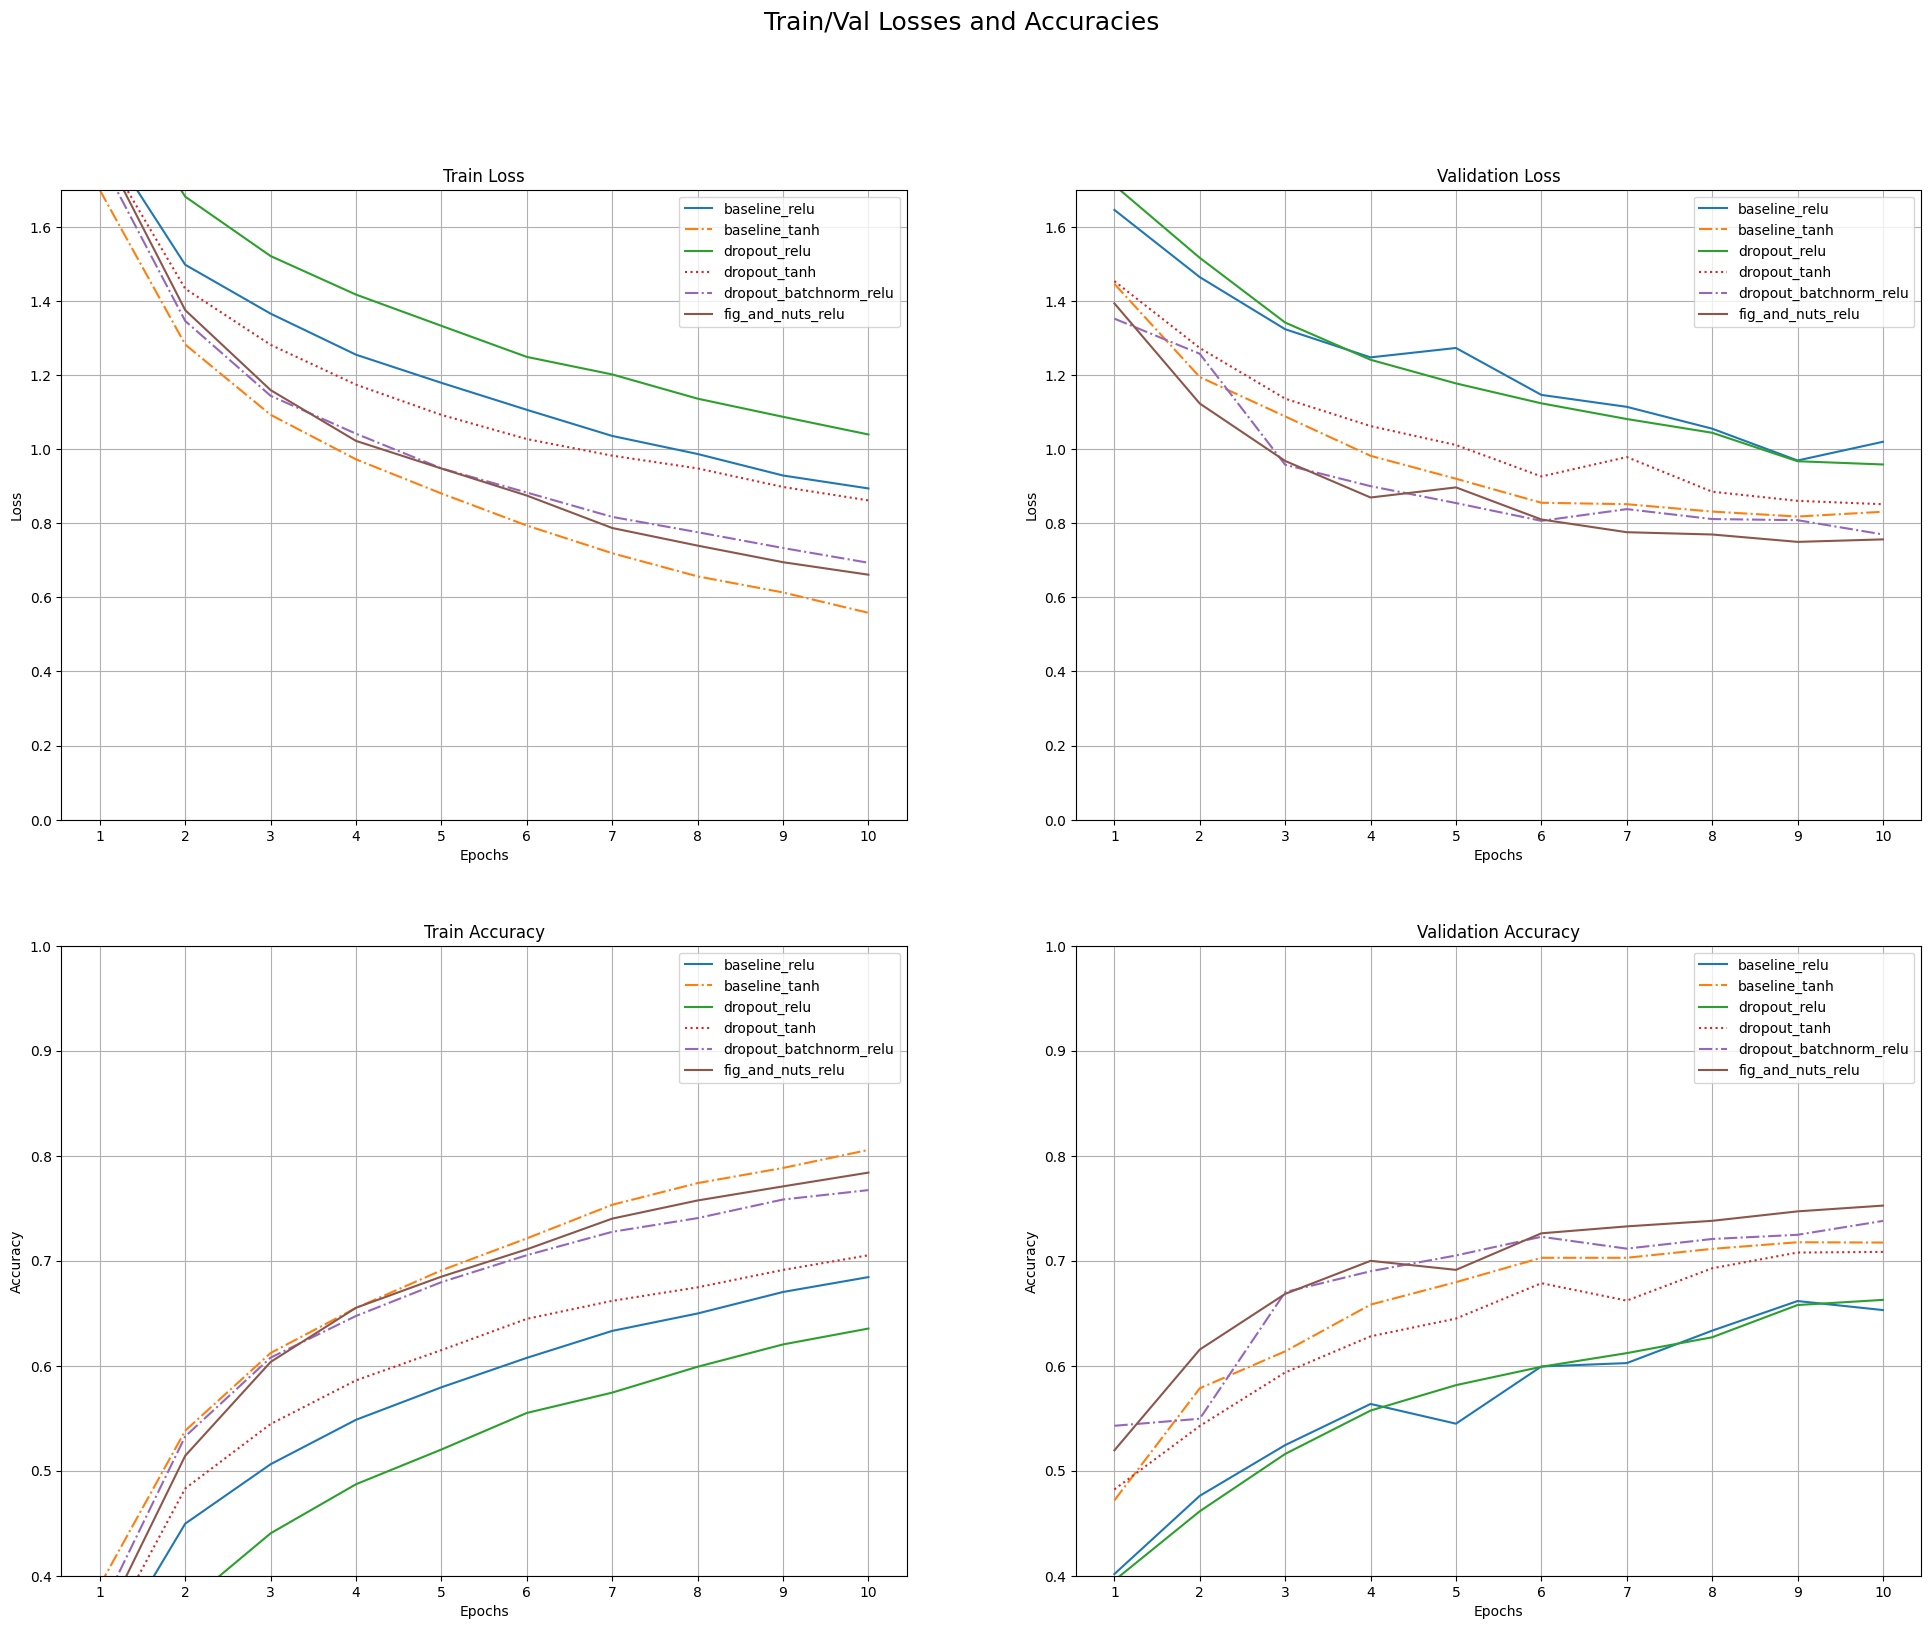

In [26]:
plot_loss_curves(n_epochs, results)

## Discussion

Discuss your findings and make a statement about whether the
results are as you expect.